### Code to remove diurnal cycle from the data and save the resulting data in a ncdf file
##### author: Claudia Acquistapace
##### what the code does for every variable: 
1) reads the original file for each day for the case study of the 2-3 feb 2020 for each variable <br> 
2) applies the function f_clean_lidar_signal_from_noise to remove noise (method based on threshold+cloud base) <br> 
3) reads the diurnal cycle file for each variable <br> 
4) resamples diurnal cycle on time res of original file <br> 
3) subtracts the diurnal cycle file from each daily file <br> 
5) stores the result of the subtraction and the original variable with noise removed in a ncdf file <br> 
##### goal: obtain in ncdf the arthus variables without noise and with diurnal cycle filtered out 
##### date: 24 Nov 2021

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime,timedelta
import matplotlib.dates as mdates
import glob
import pandas as pd
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker
def f_closest(array,value):
    '''
    # closest function
    #---------------------------------------------------------------------------------
    # date :  16.10.2017
    # author: Claudia Acquistapace
    # goal: return the index of the element of the input array that in closest to the value provided to the function
    '''
    import numpy as np
    idx = (np.abs(array-value)).argmin()
    return idx  



# output paths for plots and data files
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'
path_out ='/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/'

dict_plot_settings = {
    'labelsizeaxes':14,
    'fontSizeTitle':16,
    'fontSizeX'    :16,
    'fontSizeY'    :16,
    'cbarAspect'   :10,
    'fontSizeCbar' :16,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :22, 
    'grid'         :True}


# plots settings to be used
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']


# variable list
var_list =['T','WVMR','VW','LHF','SHF']

T_dict = {
     'var_name'  : 'T',
     'var_string': 'Temperature',
     'var_units' : ' $^{\circ}$K',
     'var_min'   : 290.,
     'var_max'   : 310.,
     'thr_min'   : 280.,
     'thr_max'   : 330.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Air temperature: 28/01-04/02'}

WVMR_dict = {
     'var_name'  : 'MR',
     'var_string': 'Water vapor mixing ratio',
     'var_units' : ' g kg$^{-1}$',
     'var_min'   : 0.,
     'var_max'   : 30.,
     'thr_min'   : 0.,
     'thr_max'   : 30.,
     'avg_time'  : '15',
     'cmap'      : 'jet',
     'title'     : 'Water vapor mixing ratio: 28/01-04/02'}

VW_dict = {
     'var_name'  : 'VW',
     'var_string': 'Vertical velocity',
     'var_units' : ' ms$^{-1}$',
     'var_min'   : -2.,
     'var_max'   : 2.,
     'thr_min'   : -5.,
     'thr_max'   : 5.,
     'avg_time'  : '15',
     'cmap'      : 'seismic',
     'title'     : 'Vertical velocity: 28/01-04/02'}

LHF_dict = {
     'var_name'  : 'LHF',    
     'var_string': 'Latent heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -250.,
     'var_max'   : 250.,
     'thr_min'   : -250.,
     'thr_max'   : 250.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Latent heat flux: 28/01-04/02'}

SHF_dict = {
     'var_name'  : 'SHF',
     'var_string': 'Sensible heat flux',
     'var_units' : ' W m$^{-2}$',
     'var_min'   : -100.,
     'var_max'   : 100.,
     'thr_min'   : -100.,
     'thr_max'   : 100.,
     'avg_time'  : '30',
     'cmap'      : 'jet',
     'title'     : 'Sensible heat flux: 28/01-04/02'}


dict_list = [T_dict, WVMR_dict, VW_dict, LHF_dict, SHF_dict]

def f_clean_lidar_signal_from_noise_v2(arthus_files, dict_var, noise_mask_file):
    '''
    date: 24/11/2021
    author: Claudia Acquistapace
    input: 
        arthus_files: ncdf file to read
        dict_var : dictionary of settings specific of the variable of interest 
        noise_mask_file: filename including the path of the noise_mask file containing the cloud base height used for the filtering
    output: arthus_data_interp. Xarray dataset containing the variables without the noise
    note: the version V2 differs from V1 because it reads only daily files, and not the entire dataset as it is for V1
    '''

    # merging data from each day in a single xarray dataset if more than one file, otherwise just read
    if len(arthus_files) > 1:
        arthus_data = xr.open_mfdataset(arthus_files)
    else:
        arthus_data = xr.open_dataset(arthus_files)

    # removing time duplicates for LHF and SHF file
    if (dict_var['var_name'] == 'LHF') | (dict_var['var_name'] == 'SHF'):
        _, index = np.unique(arthus_data['Time'], return_index=True)
        arthus_data = arthus_data.isel(Time=index)
        print('removed duplicates of time stamps')
        
        
    # set to nan the values out of the thresholds for the selected variable
    mask = (arthus_data["Product"].values > dict_var['thr_min']) & (arthus_data["Product"].values < dict_var['thr_max'])
    arthus_data["nans"] = xr.full_like(arthus_data.Product, fill_value=np.nan)
    arthus_data['Product'] = xr.where(mask, arthus_data['Product'], arthus_data["nans"])
    
    
    # opening noise mask file to read cloud base
    noise_mask_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/noise_mask.nc'
    noise_mask = xr.open_dataset(noise_mask_file)
    cloud_base = noise_mask.cloud_base_height.values

    # restricting noise mask data to the day that is read
    noise_mask = noise_mask.sel(Time=slice(arthus_data['Time'].values[0],arthus_data['Time'].values[-1]))

    # interpolating time of the arthus product (T,WVMR, LHF, SHF) on the time of the noise mask (BR ratio time res)
    arthus_data_interp = arthus_data.interp(Time=noise_mask['Time'].values)

    # find closest height of arthus data to the threshold height for every time stamp
    arthus_height_thr = []
    for ind_t in range(len(arthus_data_interp.Time.values)):
        arthus_height_thr.append(arthus_data_interp['Height'].values[f_closest(arthus_data_interp['Height'].values, cloud_base[ind_t])])    


    # building noise mask for arthus_data
    mask = np.ones((len(pd.to_datetime(arthus_data_interp['Time'].values)),len(arthus_data_interp['Height'].values)))
    for ind in range(len(pd.to_datetime(arthus_data_interp['Time'].values))):    
        ind_zero = np.where(arthus_data_interp['Height'].values > arthus_height_thr[ind])
        mask[ind,ind_zero[0]] = 0.
        

    # applying the mask to the product variable
    arthus_data_interp["nans"] = xr.full_like(arthus_data_interp.Product, fill_value=np.nan)
    arthus_data_interp['Product'] = xr.where(mask, arthus_data_interp['Product'], arthus_data_interp["nans"])
    
    return(arthus_data_interp)



processing var : Vertical velocity
process day: 20200202


<ipython-input-2-a2552802c45f>:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh1 = axs[0].pcolormesh(arthus_no_noise['Time'].values, d_cycle['Height'].values, \
<ipython-input-2-a2552802c45f>:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh1 = axs[1].pcolormesh(arthus_no_noise['Time'].values, d_cycle['Height'].values, \


processing var : Vertical velocity
process day: 20200203


<ipython-input-2-a2552802c45f>:61: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh1 = axs[0].pcolormesh(arthus_no_noise['Time'].values, d_cycle['Height'].values, \
<ipython-input-2-a2552802c45f>:79: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh1 = axs[1].pcolormesh(arthus_no_noise['Time'].values, d_cycle['Height'].values, \


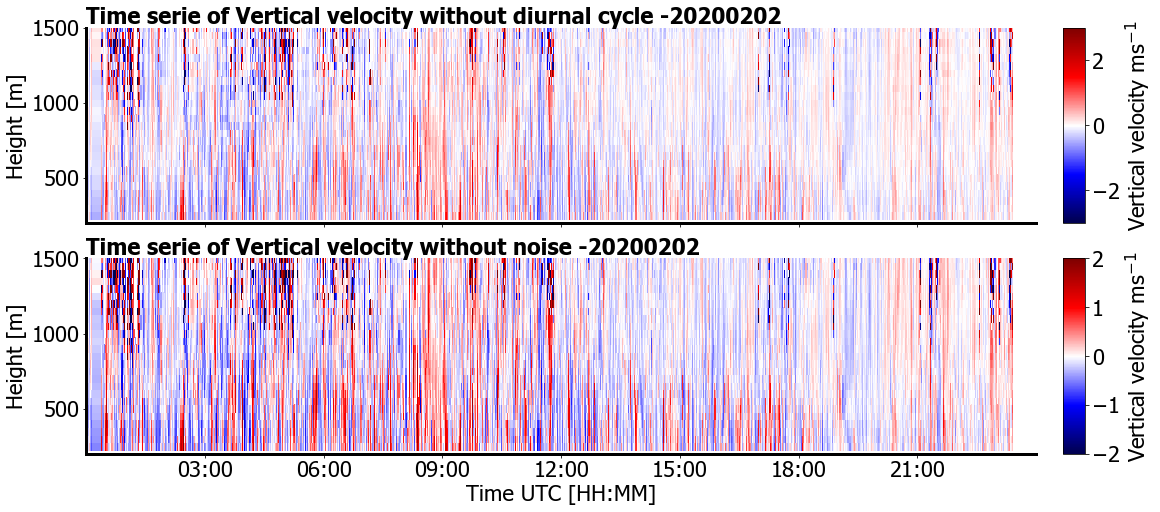

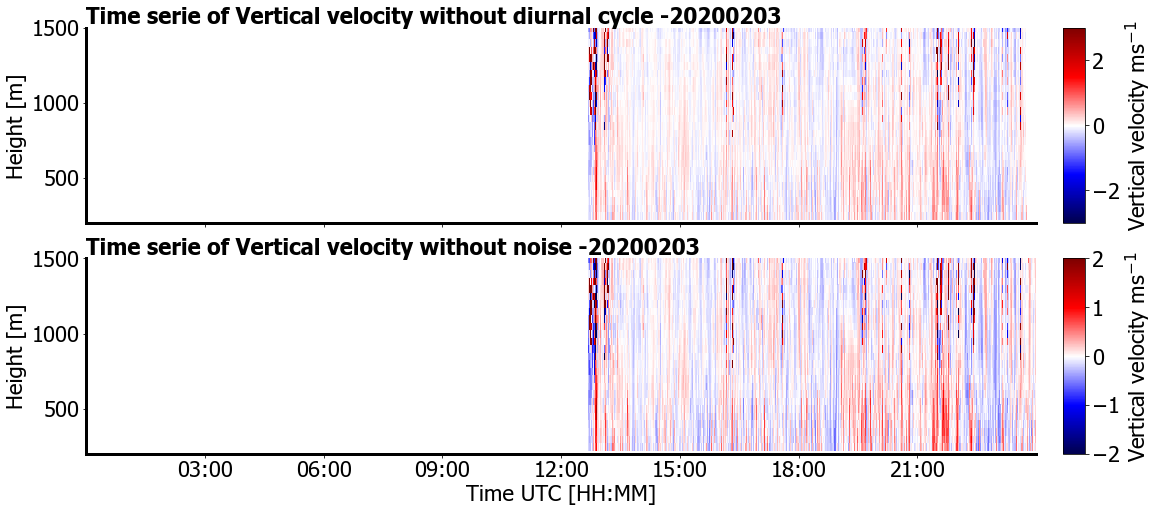

In [2]:
dict_var = VW_dict
noise_mask_file = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/noise_mask.nc'
data_path = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/'+dict_var['var_name']+'/'
arthus_files = np.sort(glob.glob(data_path+'*.cdf'))[5:7]

for i_file in range(len(arthus_files)):
    
    # reading file name
    file = arthus_files[i_file]
    print('processing var : '+dict_var['var_string'])
    
    # reading string of the date for saving output files and plots
    date = file[len(data_path):len(data_path)+8]
    print('process day: '+date)
    
    # filtering the original data from noise
    arthus_no_noise = f_clean_lidar_signal_from_noise(file, dict_var, noise_mask_file)


    # read diurnal cycle file
    d_cycle = xr.open_dataset('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/'+dict_var['var_name']+'_diurnal_cycle.nc')

    # calculate new time array for diurnal cycle
    time_start = datetime(2020,\
                        pd.to_datetime(arthus_no_noise['Time'].values)[0].month,\
                        pd.to_datetime(arthus_no_noise['Time'].values)[0].day,0,0,0)
    time_end = datetime(2020,\
                        pd.to_datetime(arthus_no_noise['Time'].values)[0].month,\
                        pd.to_datetime(arthus_no_noise['Time'].values)[0].day,23,59,59)

    new_time = np.arange(time_start, time_end, timedelta(minutes=int(dict_var['avg_time']))).astype(datetime)
    d_cycle['Time'] = new_time


    # resampling diurnal cycle on arthus time 
    #arthus_data = arthus_data.interp(Time=d_cycle['Time'].values)
    d_cycle_arthus = d_cycle.interp(Time=arthus_no_noise['Time'].values, method='nearest')

    # subtracting diurnal cycle from arthus variable
    var_no_dc = arthus_no_noise['Product'].values - d_cycle_arthus['diurnal_cycle'].values
    
    
    
    # plots settings to be used
    labelsizeaxes   = 14
    fontSizeTitle   = 16
    fontSizeX       = 16
    fontSizeY       = 16
    cbarAspect      = 10
    fontSizeCbar    = 16
    rcParams['font.sans-serif'] = ['Tahoma']
    matplotlib.rcParams['savefig.dpi'] = 100
    plt.rcParams.update({'font.size':22})
    grid = True
    fig2, axs = plt.subplots(2,1, figsize=(16,7), constrained_layout=True, sharex=True)
    axs[0].spines["top"].set_visible(False)
    axs[0].spines["right"].set_visible(False)
    axs[0].spines["bottom"].set_linewidth(3)
    axs[0].spines["left"].set_linewidth(3)
    grid=True
    mesh1 = axs[0].pcolormesh(arthus_no_noise['Time'].values, d_cycle['Height'].values, \
                                 var_no_dc.T, vmin=-3., \
                                 vmax=3., cmap='seismic', rasterized=True)
    cbar = fig2.colorbar(mesh1, ax=axs[0], label=dict_var['var_string']+dict_var['var_units'], \
                            location='right', aspect=20, use_gridspec=grid)


    axs[0].set_ylabel('Height [m]')
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[0].text(0, 1.02, 'Time serie of '+dict_var['var_string']+' without diurnal cycle -'+date, \
                fontweight='black', transform=axs[0].transAxes)
    axs[0].set_ylim(200., 1500.)

    axs[1].spines["top"].set_visible(False)
    axs[1].spines["right"].set_visible(False)
    axs[1].spines["bottom"].set_linewidth(3)
    axs[1].spines["left"].set_linewidth(3)
    grid=True
    mesh1 = axs[1].pcolormesh(arthus_no_noise['Time'].values, d_cycle['Height'].values, \
                                 arthus_no_noise['Product'].values.T, vmin=dict_var['var_min'], \
                                 vmax=dict_var['var_max'], cmap=dict_var['cmap'], rasterized=True)
    cbar = fig2.colorbar(mesh1, ax=axs[1], label=dict_var['var_string']+dict_var['var_units'], \
                            location='right', aspect=20, use_gridspec=grid)


    axs[1].set_ylabel('Height [m]')
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    axs[1].text(0, 1.02, 'Time serie of '+dict_var['var_string']+' without noise -'+date, \
                fontweight='black', transform=axs[1].transAxes)
    axs[1].set_ylim(200., 1500.)
    axs[1].set_xlabel('Time UTC [HH:MM]')
    fig2.savefig(path_out_plots+'{var_name}_'+date+'overview_anomaly_dc_no_noise.png'.format(**dict_var))

    
    
    # saving variables without diurnal cycle in a ncdf file
    # save xarray dataset containing the correction terms for the hour
    dims             = ['Time','Height']
    coords           = {"Time":arthus_no_noise['Time'].values, "Height":arthus_no_noise['Height'].values}

    var_nodc          = xr.DataArray(dims=dims, coords=coords, data=var_no_dc,
                             attrs={'long_name':dict_var['var_string']+' without diurnal cycle',
                                    'units':''})
    var_no_noise      = xr.DataArray(dims=dims, coords=coords, data=arthus_no_noise['Product'].values,
                             attrs={'long_name':dict_var['var_string']+' with noise removed',
                                    'units':dict_var['var_units']})

    variables         = {'product_no_diurnal_cycle':var_nodc,
                                     'product_no_noise':var_no_noise}
    global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                        'CREATED_ON'       :  str(datetime.now()),
                        'FILL_VALUE'       :  'NaN', 
                        'PI_NAME'          : 'Claudia Acquistapace',
                        'PI_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                        'PI_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                        'PI_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                        'DATA_DESCRIPTION' : dict_var['var_string']+'with the diurnal cycle removed from the data',
                        'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                        'DATA_GROUP'       : 'Experimental;Profile;Moving',
                        'DATA_SOURCE'      : 'arthus data',
                        'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                        'INSTRUMENT_MODEL' : 'arthus raman lidar system',
                         'COMMENT'         : 'original data postprocessed by Diego Lange' }
    dataset    = xr.Dataset(data_vars = variables,
                                      coords = coords,
                                       attrs = global_attributes)
    dataset.to_netcdf('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/post_processed_clau/'+dict_var['var_name']+'_'+date+'.nc')



'30'

In [4]:
# read diurnal cycle file
d_cycle = xr.open_dataset('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/'+dict_var['var_name']+'_diurnal_cycle.nc')

# calculate new time array for diurnal cycle
time_start = datetime(2020,\
                    pd.to_datetime(arthus_no_noise['Time'].values)[0].month,\
                    pd.to_datetime(arthus_no_noise['Time'].values)[0].day,0,0,0)
time_end = datetime(2020,\
                    pd.to_datetime(arthus_no_noise['Time'].values)[0].month,\
                    pd.to_datetime(arthus_no_noise['Time'].values)[0].day,23,59,59)

new_time = np.arange(time_start, time_end, timedelta(minutes=15)).astype(datetime)
d_cycle['Time'] = new_time


# resampling diurnal cycle on arthus time 
#arthus_data = arthus_data.interp(Time=d_cycle['Time'].values)
d_cycle_arthus = d_cycle.interp(Time=arthus_no_noise['Time'].values, method='nearest')

# subtracting diurnal cycle from arthus variable
var_no_dc = arthus_no_noise['Product'].values - d_cycle_arthus['diurnal_cycle'].values

<ipython-input-9-597a18f97fa6>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh1 = axs[0].pcolormesh(arthus_no_noise['Time'].values, d_cycle['Height'].values, \
<ipython-input-9-597a18f97fa6>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mesh1 = axs[1].pcolormesh(arthus_no_noise['Time'].values, d_cycle['Height'].values, \


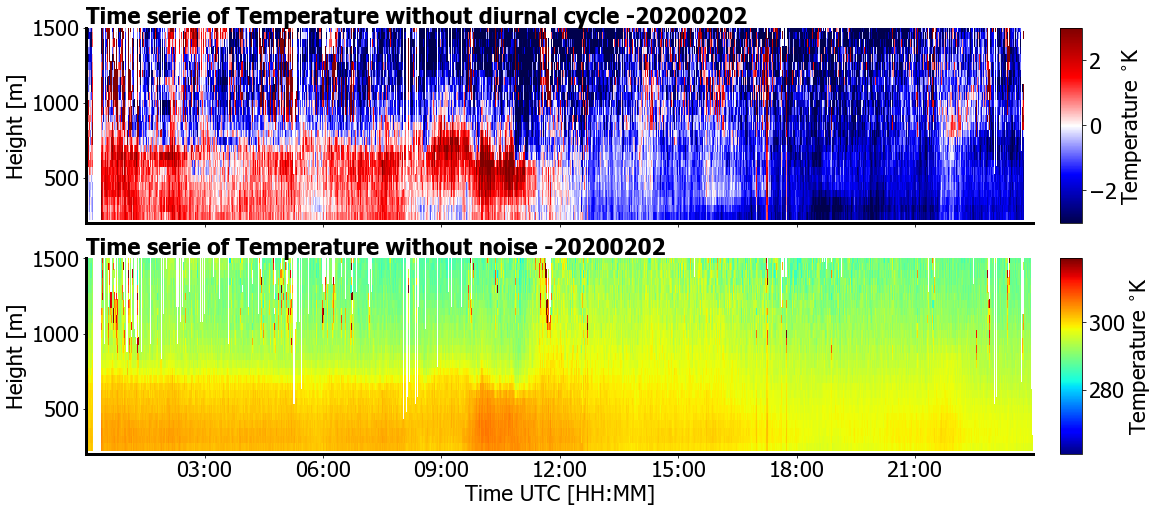

In [9]:
# plots settings to be used
labelsizeaxes   = 14
fontSizeTitle   = 16
fontSizeX       = 16
fontSizeY       = 16
cbarAspect      = 10
fontSizeCbar    = 16
rcParams['font.sans-serif'] = ['Tahoma']
matplotlib.rcParams['savefig.dpi'] = 100
plt.rcParams.update({'font.size':22})
grid = True
fig2, axs = plt.subplots(2,1, figsize=(16,7), constrained_layout=True, sharex=True)
axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["bottom"].set_linewidth(3)
axs[0].spines["left"].set_linewidth(3)
grid=True
mesh1 = axs[0].pcolormesh(arthus_no_noise['Time'].values, d_cycle['Height'].values, \
                             var_no_dc.T, vmin=-3., \
                             vmax=3., cmap='seismic', rasterized=True)
cbar = fig2.colorbar(mesh1, ax=axs[0], label=dict_var['var_string']+dict_var['var_units'], \
                        location='right', aspect=20, use_gridspec=grid)


axs[0].set_ylabel('Height [m]')
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[0].text(0, 1.02, 'Time serie of '+dict_var['var_string']+' without diurnal cycle -'+date, \
            fontweight='black', transform=axs[0].transAxes)
axs[0].set_ylim(200., 1500.)

axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["bottom"].set_linewidth(3)
axs[1].spines["left"].set_linewidth(3)
grid=True
mesh1 = axs[1].pcolormesh(arthus_no_noise['Time'].values, d_cycle['Height'].values, \
                             arthus_no_noise['Product'].values.T, vmin=dict_var['var_min'], \
                             vmax=dict_var['var_min'], cmap=dict_var['cmap'], rasterized=True)
cbar = fig2.colorbar(mesh1, ax=axs[1], label=dict_var['var_string']+dict_var['var_units'], \
                        location='right', aspect=20, use_gridspec=grid)


axs[1].set_ylabel('Height [m]')
axs[1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
axs[1].text(0, 1.02, 'Time serie of '+dict_var['var_string']+' without noise -'+date, \
            fontweight='black', transform=axs[1].transAxes)
axs[1].set_ylim(200., 1500.)
axs[1].set_xlabel('Time UTC [HH:MM]')
fig2.savefig(path_out_plots+'{var_name}_'+date+'overview_anomaly_dc_no_noise.png'.format(**dict_var))


In [6]:
# saving variables without diurnal cycle in a ncdf file
# save xarray dataset containing the correction terms for the hour
dims             = ['Time','Height']
coords           = {"Time":arthus_no_noise['Time'].values, "Height":arthus_no_noise['Height'].values}

var_nodc          = xr.DataArray(dims=dims, coords=coords, data=var_no_dc,
                         attrs={'long_name':dict_var['var_string']+' without diurnal cycle',
                                'units':''})
var_no_noise      = xr.DataArray(dims=dims, coords=coords, data=arthus_no_noise['Product'].values,
                         attrs={'long_name':dict_var['var_string']+' with noise removed',
                                'units':dict_var['var_units']})

variables         = {'product_no_diurnal_cycle':var_nodc,
                                 'product_no_noise':var_no_noise}
global_attributes = {'CREATED_BY'       : 'Claudia Acquistapace',
                    'CREATED_ON'       :  str(datetime.now()),
                    'FILL_VALUE'       :  'NaN', 
                    'PI_NAME'          : 'Claudia Acquistapace',
                    'PI_AFFILIATION'   : 'University of Cologne (UNI), Germany', 
                    'PI_ADDRESS'       : 'Institute for geophysics and meteorology, Pohligstrasse 3, 50969 Koeln', 
                    'PI_MAIL'          : 'cacquist@meteo.uni-koeln.de',
                    'DATA_DESCRIPTION' : dict_var['var_string']+'with the diurnal cycle removed from the data',
                    'DATA_DISCIPLINE'  : 'Atmospheric Physics - Remote Sensing Lidar Profiler',
                    'DATA_GROUP'       : 'Experimental;Profile;Moving',
                    'DATA_SOURCE'      : 'arthus data',
                    'DATA_PROCESSING'  : 'https://github.com/ClauClouds/SST-impact/',
                    'INSTRUMENT_MODEL' : 'arthus raman lidar system',
                     'COMMENT'         : 'original data postprocessed by Diego Lange' }
dataset    = xr.Dataset(data_vars = variables,
                                  coords = coords,
                                   attrs = global_attributes)
dataset.to_netcdf('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/arthus_data/post_processed_clau/'+dict_var['var_name']+'_'+date+'.nc')



In [38]:
dict_var['var_min']

290.0